In [0]:
!pip install torch torchvision

In [0]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

# Retinal Vessel Detection

Dataset used: *[DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/)*

Loading dataset on colab...

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive/"My Drive"/datasets

/content/drive/My Drive/datasets


In [0]:
cp DRIVE.zip ../../../

In [0]:
!unzip DRIVE.zip

In [9]:
ls

ALL_IDB2.rar  DRIVE/  DRIVE.zip


# Crop Images

Multiple pixel and the challenge is to label each and every pixel. Annotate each pixel known as sementic segmentation.
Take a 10x10 patch, and the center pixels label is associated with that patch.

In [0]:
# crop random 10 x 10 patches from images and also get the corresponding label

def img_transfer(img,imgLabel, bh, bw, no_of_patch):
    
    h = img.shape[0]
    w = img.shape[1]
    c = img.shape[2]
    ImgArr = np.empty((no_of_patch, bh*bw*3)) 
    LabelArr = np.empty((no_of_patch, bh*bw*1))
    
    # Get random patches
    for i in range(no_of_patch):
        ih = random.randint(0, h-bh)
        iw = random.randint(0, w-bw)
        iArrI = img[ih:ih+bh,iw:iw+bw,:]
        iArrL = imgLabel[ih:ih+bh,iw:iw+bw,:]       
        for ci in range(c):
            for bhi in range(bh):
                for bwi in range(bw):
                    # Add to image array
                    ImgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
                    # first channel
                    if ci == 0:
                        LabelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
        
    return ImgArr,LabelArr

In [0]:
def create_dset(patchH, patchW, PatchperImage, settype='train'):
  """
  patchH: Patch height
  patchW: Patch width
  PatchperImage: Number of patches per image
  settype: Can be either train or test
  """
  if settype == 'train':
    Datapath = 'DRIVE/training/images/'
    # 2 different annotations by different oplthalmologists
    Labelpath = 'DRIVE/training/1st_manual/'
  elif settype == 'test':
    Datapath = 'DRIVE/test/images/'
    # 2 different annotations by different oplthalmologists
    Labelpath = 'DRIVE/test/1st_manual/'
  else:
    raise ValueError("settype can be either 'test' or 'train'")
  
  images = torch.DoubleTensor(20*PatchperImage,3*patchH*patchW) # 20 such images
  labels = torch.DoubleTensor(20*PatchperImage,patchH*patchW) 
  t_no = 0
  for img_no in range(20):
      if settype == 'train':
        dp = Datapath + str(img_no+21) + '_training.tif'
        lp = Labelpath + str(img_no+21) + '_manual1.gif'
      elif settype == 'test':
        dp = Datapath + "%02d"%(img_no+1) + '_test.tif'
        lp = Labelpath + "%02d"%(img_no+1) + '_manual1.gif'
      imD = Image.open(dp)
      imD = np.array(imD)    

      imL = Image.open(lp)
      imL = np.array(imL)
      imL = np.reshape(imL, (imL.shape[0],imL.shape[1],1))

      imD,imL = img_transfer(imD,imL, patchH, patchW, PatchperImage)
      imD = imD/255.0
      imL = imL/255.0
      for i in range(PatchperImage):
          images[t_no] = torch.from_numpy(imD[i])
          labels[t_no] = torch.from_numpy(imL[i])
          t_no = t_no + 1
  return images, labels
    

# Model 1: Basic Autoencoder

In [0]:
patchH = 10 # height of the patch
patchW = 10 # width of the patch
PatchperImage = 1000 # no of patches per image

In [0]:
TrainImages,TrainLabels = create_dset(patchH, patchW, PatchperImage, settype='train')

In [0]:
TestImages, TestLabels = create_dset(patchH, patchW, PatchperImage, settype='test')

In [44]:
print(TrainImages.size())
print(TrainLabels.size())

print(TestImages.size())
print(TestLabels.size())

torch.Size([20000, 300])
torch.Size([20000, 100])
torch.Size([20000, 300])
torch.Size([20000, 100])


In [0]:
batch_size = 32
n_iters = 50000
num_epochs = int(n_iters / (len(TrainImages)/batch_size))

train_dataset = torch.utils.data.TensorDataset(TrainImages, TrainLabels)
test_dataset = torch.utils.data.TensorDataset(TestImages, TestLabels)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [46]:
print(n_iters)
print(num_epochs)

50000
80


In [47]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


In [48]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(patchH*patchW*3, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW,patchH*patchW*3),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
    

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)


In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [34]:
trainLoss = []

iter = 0
for epoch in range(num_epochs):
  runningLoss = 0
  for images, labels in train_loader:
    
    if use_gpu:
      images = Variable(images).cuda() # No need to resize
    else:
      images = Variable(images) # No need to resize  
    
    optimizer.zero_grad()
    
    outputs = net(images)
    
    loss = criterion(outputs, images)
    
    loss.backward()
    
    optimizer.step()
    
    runningLoss += loss.data[0]
  trainLoss.append(runningLoss/(TrainImages.size()[0]/batch_size))
  if epoch % 10 == 0:
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,num_epochs,runningLoss/
                                                                (TrainImages.size()[0]/batch_size)))
print('Finished Training')
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 80  ;  Mean-Squared Error : 0.008797
At Iteration : 11 / 80  ;  Mean-Squared Error : 0.000523
At Iteration : 21 / 80  ;  Mean-Squared Error : 0.000336
At Iteration : 31 / 80  ;  Mean-Squared Error : 0.000274
At Iteration : 41 / 80  ;  Mean-Squared Error : 0.000244
At Iteration : 51 / 80  ;  Mean-Squared Error : 0.000217
At Iteration : 61 / 80  ;  Mean-Squared Error : 0.000203
At Iteration : 71 / 80  ;  Mean-Squared Error : 0.000186
Finished Training


Text(0,0.5,'Training loss')

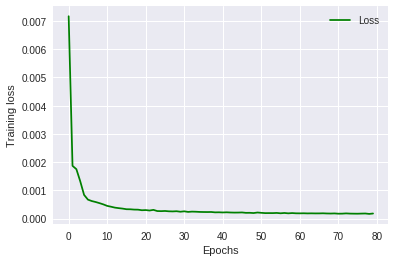

In [129]:
fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

## Modifying the autoencoder for classification

In [49]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW),nn.Sigmoid()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


In [0]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [70]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.data[0]
        
    testloss = 0.0
    for data in test_loader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        testloss += loss.data[0]
    if epoch % 10 == 0:  
      print('At Iteration : %d / %d  ;  Train Error : %f ;Test Error : %f'%(epoch + 1,num_epochs,
                                                                        runningLoss/(20000/batch_size),testloss/(20000/batch_size)))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 80  ;  Train Error : 0.207724 ;Test Error : 0.208494
At Iteration : 11 / 80  ;  Train Error : 0.198806 ;Test Error : 0.201863
At Iteration : 21 / 80  ;  Train Error : 0.193013 ;Test Error : 0.191292
At Iteration : 31 / 80  ;  Train Error : 0.188357 ;Test Error : 0.187961
At Iteration : 41 / 80  ;  Train Error : 0.186861 ;Test Error : 0.184599
At Iteration : 51 / 80  ;  Train Error : 0.181693 ;Test Error : 0.179976
At Iteration : 61 / 80  ;  Train Error : 0.180625 ;Test Error : 0.181124
At Iteration : 71 / 80  ;  Train Error : 0.177603 ;Test Error : 0.180171
Finished Training


In [0]:
# still not sure about testing the accuracy

In [0]:
imD = Image.open('DRIVE/test/images/01_test.tif')
imD = np.array(imD) 
imD = imD/255.0
    
imL = Image.open('DRIVE/test/1st_manual/01_manual1.gif')
imL = np.array(imL)
imL = imL/255.0

In [0]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(imD.shape[0]//patchH):
    for j in range(imD.shape[1]//patchW):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(Variable(TestTensor.double().cuda()))
        outArr = out.data.cpu().numpy()
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3]

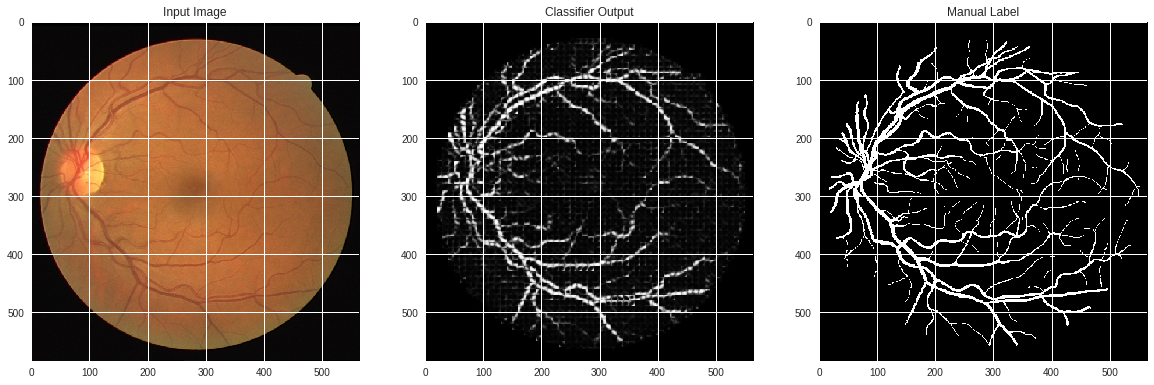

In [85]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
plt.figure()
plt.subplot(1, 3, 1)
npimg = imD
npimg = np.abs(npimg)
plt.title('Input Image')
plt.imshow(npimg)

plt.subplot(1, 3, 2)
npimg = imout
npimg = np.abs(npimg)
plt.title('Classifier Output')
plt.imshow(npimg, 'gray')

plt.subplot(1, 3, 3)
npimg = imL
npimg = np.abs(npimg)
plt.title('Manual Label')
plt.imshow(npimg, 'gray')